<div align="center">
    <h1><em><strong>Rice Leaf Disease Prediction</strong></em></h1>
</div>

### 🌾 Exploratory Data Analysis (EDA)

The dataset used for this project consists of **rice leaf images** categorized into three major disease types:
- **Leaf Blast**
- **Bacterial Blight**
- **Brown Spot**

EDA was conducted to understand the dataset before applying any deep learning model.

#### 🔍 Key Observations:
- The dataset is **clean and well-structured**, containing images of uniform format and resolution.  
- The **class distribution** is relatively balanced, ensuring no bias toward a particular disease type.  
- **Sample visualizations** provide clear insights into the texture, color, and pattern variations between healthy and infected leaves.  
- No missing or corrupted files were detected.  
- The data is suitable for further steps like **image preprocessing**, **data augmentation**, and **CNN model training**.

#### ✅ Insights and Readiness:
- The EDA confirms that the dataset provides sufficient variation among classes, enabling effective feature extraction using CNNs.  
- Proper preprocessing steps (resizing, normalization, augmentation) will enhance generalization and model performance.  


Exploratory Data Analysis (EDA)

In [17]:
# Import the Required Libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns

In [18]:
print(os.listdir('RiceLeaf Dataset'))

['Bacterial leaf blight', 'Brown spot', 'Leaf Smut']


In [19]:
df_counts = pd.DataFrame(list(image_counts.items()), columns=['Disease', 'Image_Count'])
print(df_counts)

                 Disease  Image_Count
0  Bacterial leaf blight           40
1             Brown spot           40
2              Leaf Smut           39


C:\Users\suvaa\AppData\Local\Temp\ipykernel_25332\495006386.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Disease', y='Image_Count', data=df_counts, palette='viridis')


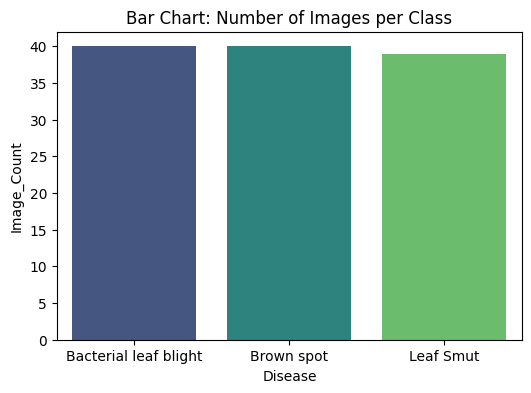

In [20]:
# Bar Chart for Clear numeric comparison
plt.figure(figsize=(6,4))
sns.barplot(x='Disease', y='Image_Count', data=df_counts, palette='viridis')
plt.title('Bar Chart: Number of Images per Class')
plt.show()

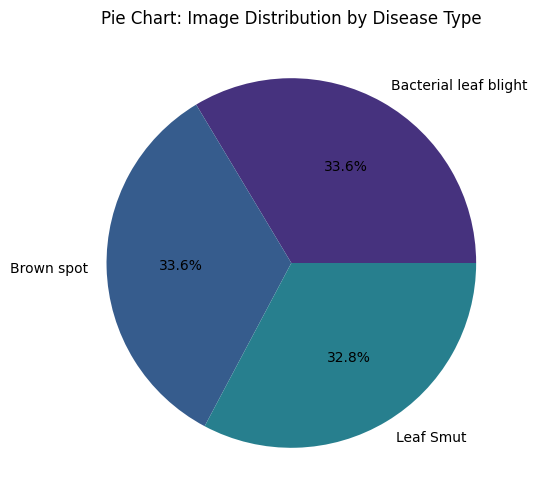

In [21]:
# Pie Chart to Easily spot imbalance
plt.figure(figsize=(6, 6))  # Set the figure size (width, height)
plt.pie(
    df_counts['Image_Count'],               # Values (number of images per disease)
    labels=df_counts['Disease'],            # Labels for each slice
    autopct='%1.1f%%',                      # Display percentage values with 1 decimal point
    colors=sns.color_palette('viridis'),    # Use the same Seaborn color palette for consistency
)
plt.title('Pie Chart: Image Distribution by Disease Type')  # Title of the chart
plt.show()

C:\Users\suvaa\AppData\Local\Temp\ipykernel_25332\4050950372.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Disease', x='Image_Count', data=df_counts, palette='cool')


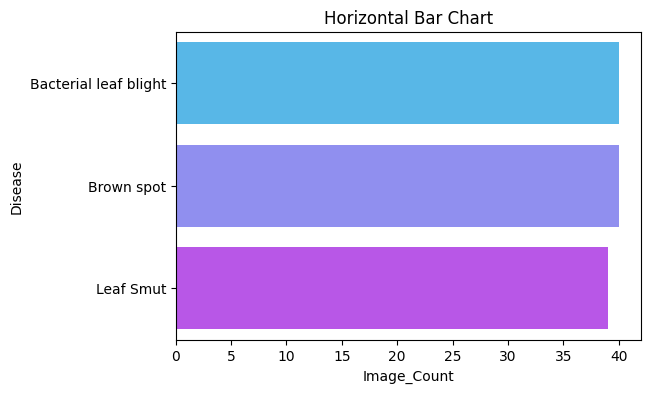

In [22]:
#Horizontal Bar Chart for Making report cleaner
plt.figure(figsize=(6,4))
sns.barplot(y='Disease', x='Image_Count', data=df_counts, palette='cool')
plt.title('Horizontal Bar Chart')
plt.show()

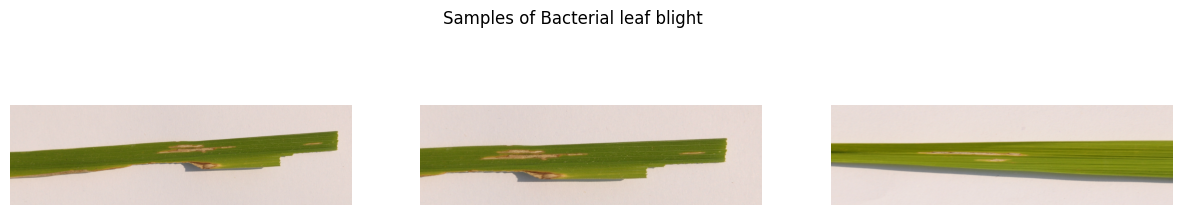

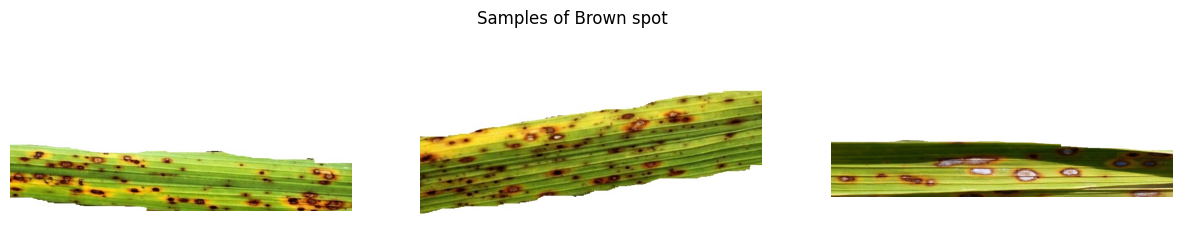

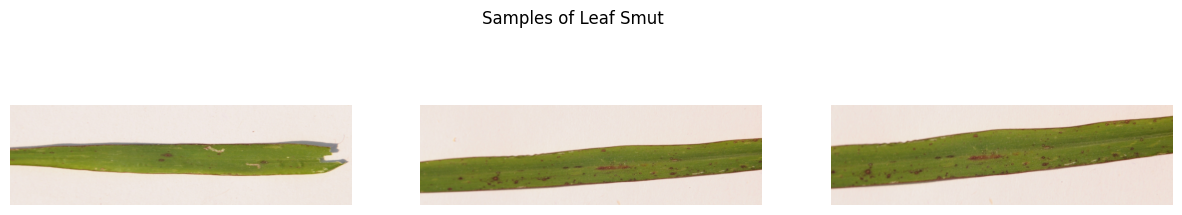

In [23]:
#Sample Images -- Gives visual understanding of each folder
for category in os.listdir(data_dir):
    folder = os.path.join(data_dir, category)
    sample_imgs = os.listdir(folder)[:3]  # Take first 3 images

    plt.figure(figsize=(15,3))
    plt.suptitle(f"Samples of {category}", fontsize=12)

    for i, img_name in enumerate(sample_imgs):
        img = mpimg.imread(os.path.join(folder, img_name))
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

**Conclusion:** The Exploratory Data Analysis verifies that the Rice Leaf Disease dataset is ready for preprocessing and model development using Convolutional Neural Networks (CNN).